# Exploratory data analysis on unlabeled data
We don't have labeled data yet, but we can still examine the data to see if there is something that stands out. 

## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import sqlite3

with sqlite3.connect('logs/logs.db') as conn:
    logs_2018 = pd.read_sql(
        """
        SELECT * 
        FROM logs 
        WHERE datetime BETWEEN "2018-01-01" AND "2019-01-01";
        """, 
        conn, parse_dates=['datetime'], index_col='datetime'
    )
logs_2018.head()

,source_ip,username,success,failure_reason
datetime,,,,
2018-01-01 00:06:19.353126,223.178.55.3,djones,1,None
2018-01-01 00:09:07.147971,223.178.55.3,djones,1,None
2018-01-01 01:08:08.610041,6.252.142.27,asmith,1,None
2018-01-01 02:37:50.329298,124.178.25.98,akim,1,None
2018-01-01 02:45:20.382080,98.43.141.103,akim,1,None


## EDA

In [3]:
logs_2018.dtypes

source_ip         object
username          object
success            int64
failure_reason    object
dtype: object

In [4]:
logs_2018.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43283 entries, 2018-01-01 00:06:19.353126 to 2018-12-31 23:24:52.807237
Data columns (total 4 columns):
source_ip         43283 non-null object
username          43283 non-null object
success           43283 non-null int64
failure_reason    19127 non-null object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


In [5]:
logs_2018.describe(include='all')

,source_ip,username,success,failure_reason
count,43283,43283,43283.000000,19127
unique,11559,3351,NaN,2
top,78.174.30.56,kim,NaN,error_wrong_username
freq,248,352,NaN,11815
mean,NaN,NaN,0.558094,NaN
std,NaN,NaN,0.496619,NaN
min,NaN,NaN,0.000000,NaN
25%,NaN,NaN,0.000000,NaN
50%,NaN,NaN,1.000000,NaN
75%,NaN,NaN,1.000000,NaN


### Distinct users per IP

In [6]:
logs_2018.groupby('source_ip').agg(
    dict(username='nunique')
).username.value_counts().describe()

count       12.000000
mean       963.250000
std       2979.691385
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max      10363.000000
Name: username, dtype: float64

### Calculate metrics per IP

In [7]:
pivot = pd.pivot_table(
    logs_2018, values='success', index=logs_2018.source_ip, 
    columns=logs_2018.failure_reason.fillna('success'), 
    aggfunc='count', fill_value=0
)
pivot.insert(0, 'attempts', pivot.sum(axis=1))
pivot = pivot.sort_values('attempts', ascending=False).assign(
    success_rate=lambda x: x.success / x.attempts,
    error_rate=lambda x: 1 - x.success_rate
)
pivot.head()

failure_reason,attempts,error_wrong_password,error_wrong_username,success,success_rate,error_rate
source_ip,,,,,,
78.174.30.56,248,67,141,40,0.161290,0.838710
228.144.254.255,243,71,130,42,0.172840,0.827160
215.189.60.53,211,75,106,30,0.142180,0.857820
158.11.94.79,210,2,0,208,0.990476,0.009524
226.227.77.216,193,1,0,192,0.994819,0.005181


### Visual Anomaly Detection

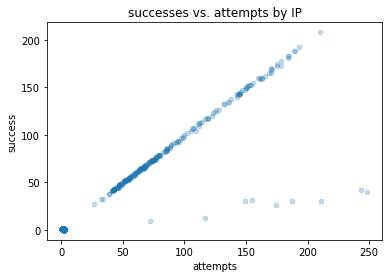

In [8]:
pivot.plot(
    kind='scatter', x='attempts', y='success', 
    title='successes vs. attempts by IP', alpha=0.25
)

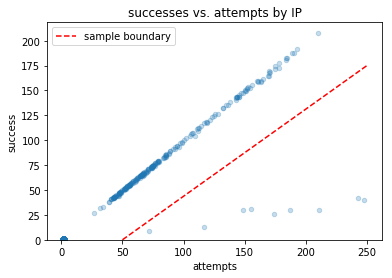

In [9]:
ax = pivot.plot(
    kind='scatter', x='attempts', y='success', 
    title='successes vs. attempts by IP', alpha=0.25
)
ax.plot([50, 250], [0, 175], 'r--', label='sample boundary')
plt.ylim(0, None)
plt.legend()

More IPs are hacker IPs because they get a new IP for each attack, while the valid users stick with the 1-3 they have. This makes the outliers on successes the valid users instead of the hackers.

attempts       AxesSubplot(0.125,0.125;0.352273x0.755)
success     AxesSubplot(0.547727,0.125;0.352273x0.755)
dtype: object

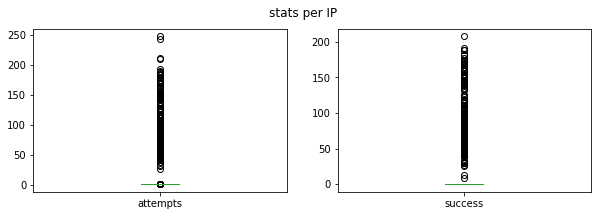

In [10]:
pivot[['attempts', 'success']].plot(
    kind='box', subplots=True, figsize=(10, 3),
    title='stats per IP'
)

Does looking at this on a minute resolution make anything stand out?

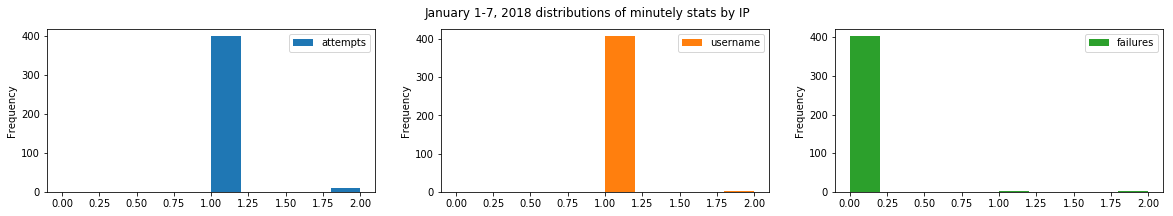

In [11]:
ax = logs_2018['2018-01-01':'2018-01-07'].assign(
    failures=lambda x: 1 - x.success
).groupby('source_ip').resample('1min').agg(
    {'username': 'nunique', 'success':'sum', 'failures': 'sum'}
).assign(
    attempts=lambda x: x.success + x.failures
).dropna().query('attempts > 0').reset_index().plot(
    y=['attempts', 'username', 'failures'], kind='hist',
    subplots=True, layout=(1, 3), figsize=(20, 3),
    title='January 1-7, 2018 distributions of minutely stats by IP'
)

There seems to be something with the number of usernames with failures per minute that we can use.

Text(0, 0.5, 'usernames with failures')

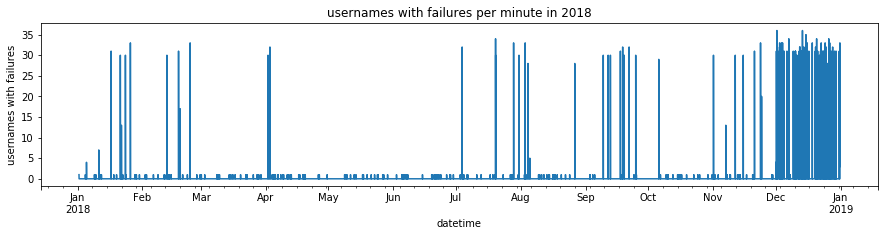

In [12]:
logs_2018['2018'].assign(
    failures=lambda x: 1 - x.success
).query('failures > 0').resample('1min').agg(
    {'username':'nunique', 'failures': 'sum'}
).dropna().rename(
    columns={'username':'usernames_with_failures'}
).usernames_with_failures.plot(
    title='usernames with failures per minute in 2018',
    figsize=(15, 3)
).set_ylabel('usernames with failures')